# Predicting geographical distribution of species using MaxEnt: a reproducible reconstruction

Author: *Santiago Núñez-Corrales (UIUC)*

Mentors: *Prof. Bertram Ludäscher (UIUC), Prof. Nico Franz (ASU)*


## Introduction

In this Tale, we focus on recostructing the work by [Phillips, Anderson and Schapire (2006)](https://www.sciencedirect.com/science/article/pii/S030438000500267X) using MaxEnt, an implementation of the maximum entropy algorithm for estimating probability distributions using prior data. Apart from the technical details, we use existing code from the scikit-learn library to generate graphics similar to those present in the publication. This tale only provides the base case, and is intended to illustrate how to harness a support vector machine in order to solve the MaxEnt estimation problem with background data.

For this particular example, we use the origina datasets already included in *scikit-learn*, our *intros-MaxEnt* and openly available background data.

## The ecological niche problem

In ecology, estimating the distribution of a species is required for a wide variety of reasons. For instance, planning field trips and evaluating the ecological risks for an organism often requires balancing the need for accurate information with pragmatic considerations that include collection time and cost. Then, formally, we can state the main biological question as follows:

>Given existing presence observations of an organism of a certain species, what is the probability distribution that is likely to be most consistent if further similar measurements were performed?

As with any prediction problem, we would like the solution to have certain useful properties:
- The mechanics of how the estimation is constructed should be easy to understand
- Given that we only know positive measurement instances, the prediction should not explicitly require absence data
- The solution process should avoid if possible a landscape with many local extrema
- The outcome should be locally informative (i.e. provide as much information as allowed by the data for a given location) and globally sensible (i.e. follow expected biological intuitions from experts)

What determines the presence of a given species from the biological point of view varies between species. First, recall that estimating geographical distributions *per se* can be decoupled from the space where observations are recorded. A geolocation is a planar approximation of a spheroid, which is assumed to be valid for small patches of land and itself carries no differentiating information between one location and another. One of our requirements for a good prediction should include a set of features per each location that were pertinent to the biology of the organism in question. In the case of vascular plants, for instance, depend strongly on the combination of soil moisture and nutrient gradients, which are indirect proxies for interactions with fungal species. Essentially, any model for predicting ecological niche distribution also requires accounting for the biological relation between the organism and its preferential environments. 

An ecological niche is often defined for a finite territory, since it is often the case that organisms have arrived at solutions that maximize their local adaptation to the environment. Recall that [evolution at the organism level](https://www.jstor.org/stable/2400240?seq=1#page_scan_tab_contents) is one where local evolutionary operators dominate in terms of outcomes, and global features combine with local ones through various interactions. To that extent, not all features will be differentiators. In order to maximize the likelihood of finding a model that is parsimonious, the geographical boundaries should be well delimited and the features chosen to partition the space of possibly different environments.

Given all the latter observations, we may re-write the original **ecological niche modeling problem** as follows:

>Given existing presence-only observation data of an organism of a certain species and geolocated data about environmental conditions relevant to the biology of the species, what is the probability distribution that is likely to be most consistent if further similar measurements were performed?

## MaxEnt from the ground up: reconstructing the mathematics
MaxEnt is learning method where the main intuition is as follows:

>The probability of finding a species at specific location should increment significantly with each biologically relevant favorable factor that is present across the niche of interest.

We wish to find a probability distribution that reflects this upon parametrization. Fortunately, we recall the existence of the [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution). In order to interpret MaxEnt, our interest in this section will be to build all the necessary mathematical intuitions and how these map onto possible facts in biology.

### Quick review: the normalized Poisson model

Let consider that a series of points $1, 2, ... i, ... n$, each with an associated *affinity* value $F_i$. The affinity may be interpreted in this context as the value assigned to the collection of features that impact the organism in the environmental background which maximizes the likelihood of a member of a species to be present. If all we had was the list of locations and their given affinity levels, the probability would be given by

$$P(i) = \frac{e^{F_i}}{\sum_{i=1}^{n} e^{F_i}}$$


$P(i)$ is called a **relative occurrence rate (ROR)** since the normalization indicates that the computation is *relative* only to the locations of interest. For instance, it would be of little use to include bodies of water for plant species adapted to high elevations. We recognize at first glance that the predicted number of observations per location is equivalent to a (normalized) [Poisson model](http://data.princeton.edu/wws509/notes/c4.pdf):

$$y_i = e^{F_i}$$

The form of $F_i$ will be defined shortly. But before, we can experiment with Python to gain an intuition of how this distribution looks like. First, we define the density function for one value, and then the distribution. For this part, we will require the **numpy** and **matplotlib** libraries.

In [8]:
#!pip install ipywidgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def affinity_density(x, obs):
    b = np.apply_along_axis(np.exp, 0, obs)
    return np.exp(x)/np.sum(b)

def affinity_distribution(locations, affinities, show):
    if show:
        for (i,x) in np.nditer([locations, affinities]):
            print("Energy for location {}: {:.4}".format(i, x))
            print("Probability: {:.5}".format(affinity_density(x, affinities)))        
            print("")
        
    return np.apply_along_axis(affinity_density, 0, arr=affinities, obs=affinities)

In [10]:
locations = np.arange(10)
affinities = np.random.rand(10)

bdist = affinity_distribution(locations, affinities, show=True)

print("Sum of probability: {:.6}".format(np.sum(bdist)))

Energy for location 0: 0.5345
Probability: 0.092061

Energy for location 1: 0.284
Probability: 0.071662

Energy for location 2: 0.6796
Probability: 0.10643

Energy for location 3: 0.5675
Probability: 0.095148

Energy for location 4: 0.663
Probability: 0.10468

Energy for location 5: 0.6689
Probability: 0.10531

Energy for location 6: 0.9189
Probability: 0.13522

Energy for location 7: 0.3492
Probability: 0.076485

Energy for location 8: 0.7753
Probability: 0.11713

Energy for location 9: 0.5751
Probability: 0.095876

Sum of probability: 1.0


We compute a scatter plot to observe how values distribute in this case:

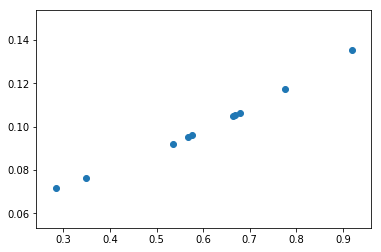

In [11]:
#dbins = [-2.0, -1.8, -1.6,-1.4,-1.2,-1-0.-9,-0.8,-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

plt.scatter(affinities, bdist)
plt.show()

As we can observe, the smaller the affinity (i.e. adequateness of a niche), the less probable an event (i.e. finding a certain member of a species) becomes. When dealing with geolocated data, it is customary to have a *raster* image whose pixels are associated with a (latitude, longitude) pair. A reasonable number of pixels for an example would be at least 100x100 = 10000.

Let us repeat the exercise above with this number of locations $N$ and affinities (this time we turn off showing the affinity and probability, and rescale the affinities by a constant proportional to $\sqrt{N}$) :

Sum of probability: 1.0


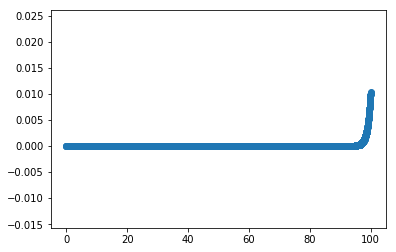

In [12]:
locations_large = np.arange(10000)
affinities_large = 100*np.random.rand(10000)

bdist_large = affinity_distribution(locations_large, affinities_large, show=False)

print("Sum of probability: {:.6}".format(np.sum(bdist_large)))

plt.scatter(affinities_large, bdist_large)
plt.show()

As the previous graph suggests, the more samples are obtained, the fraction of samples that will have a large probability will be smaller. Intuitively, given that biological evolution is a process determined by the ability to adapt locally, certain traits will gain importance for survival in the restricted geographical space that defines the niche. Notice also that this example corresponds to our *null* hypothesis that assumes that the affinity values are randomly and uniformly distributed across the landscape.

We now want to make the form of $F_i$ refer somehow to properties of the locations. One the one hand, the form should reflect the presence of various factors for which data is assumed to exist for the complete geographical landscape. On the other hand, not all the factors have the same importance for members of one species with respect to members of other species. This assumption is by how the evolution of the phenotypic distribution within a species tends to be [isogenic](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.75.061909) over time. In simple terms, *different species assign different weights to common combinations of background features that may be collectively encountered*.

Departing from the latter, we may express the affinities as some form of product between values for features present at a given location ($\boldsymbol{z}_i$) and the weight that the species assigns to features regardless of location ($\boldsymbol{\lambda}$). In practice, $\boldsymbol{z}_i$ is a vector whose entries are georeferenced background measurements of variables such as elevation, temperature, humidity, rainfall or soil type. As a general principle, the value of $\boldsymbol{\lambda}$ is hard to know in practice and has to be guessed by various means for each particular scenario and is itself a vector. Recapitulating, by computing the [dot product](https://en.wikipedia.org/wiki/Dot_product) 

$$F_i = \boldsymbol{z}_i \boldsymbol{\cdot} \boldsymbol{\lambda}$$ 

and making explicit the dependency on the feature per (georreferenced) location $x_i$ instead of $i$ we obtain

$$P^*(\boldsymbol{z}(x_i)) = \frac{e^{\boldsymbol{z}(x_i) \boldsymbol{\cdot} \boldsymbol{\lambda}}}{\sum_{i=1}^{n} e^{\boldsymbol{z}(x_i) \boldsymbol{\cdot} \boldsymbol{\lambda}}}$$

Note that one of the immediate limitations is that we take (lat, lon) data and remove its geometrical and topological properties (e.g. distance, proximity). This unrealistic with respect to how biology works, but the task at hand is not to provide an explanation of the observed distribution for a *moment fixed in time*. And, more over, we want to avoid features that complexify the interpretation of the main phenomenology described in the model (i.e. the affinity between organisms and niche features).

Let us construct now extend our code in order to use vectors and matrices, assuming they have the right dimensions. First, we update our definitions for the affinity density and distribution functions (removing the show parameter):

In [24]:
def expdotprod(z, l):
    return np.exp(np.dot(z,l))

def affinity_density_poisson(factors, flist, wght):
    b = np.apply_along_axis(expdotprod, 1, arr=flist, l=wght)
    return expdotprod(factors, wght)/np.sum(b)

def affinity_distribution_poisson(background, weights):
    return np.apply_along_axis(affinity_density_poisson, 1, arr=background, flist=background, wght=weights)

Now, we will test the code above with a 2D array containing data for 100 locations and 3 features with random data. In order to accomplish the latter, the weights will be controlled using interactive widgets. For each feature, we will plot how the probability model distributes based on changes in $\boldsymbol{\lambda}$.

In [54]:
def simple_affinity_model(background, weights, graphs=False):
    distribution = affinity_distribution_poisson(background, weights)
    
    # Iterate per column and compute the corresponding feature graphics if required
    if graphs:
        for factor in np.rollaxis(background, 1):
            plt.scatter(factor, distribution)
            plt.show()
        
    return distribution

First, it is useful to perform a couple tests to get a sense of the effect of changing the values of $\boldsymbol{\lambda}$ in order to gain a quick intuition.

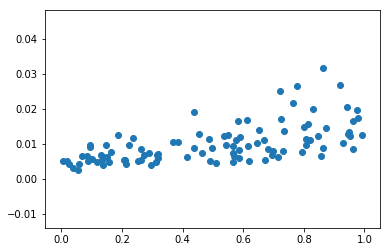

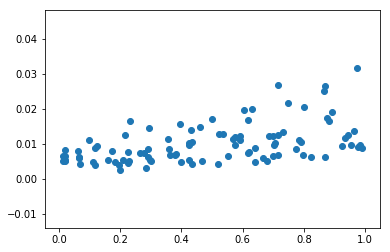

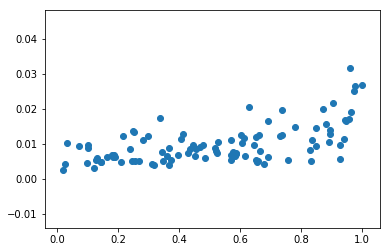

[0.01247113 0.00968988 0.01909971 0.01059849 0.00921956 0.00493631
 0.02666728 0.01484729 0.00475026 0.01265218 0.00859852 0.00643344
 0.01693577 0.00845713 0.00801467 0.00529412 0.00672604 0.00889661
 0.00536526 0.00505652 0.00486625 0.00389674 0.01116395 0.00900571
 0.01963906 0.00300069 0.00401285 0.00621853 0.00747743 0.00954324
 0.0058969  0.00633174 0.00810281 0.00499866 0.0135013  0.01099127
 0.00977283 0.01218219 0.01561227 0.01664633 0.017104   0.01028708
 0.00514277 0.00734127 0.00526126 0.01188229 0.01396729 0.01050657
 0.00965002 0.02682196 0.0062759  0.00943134 0.01147595 0.00653249
 0.02504338 0.00658073 0.00799892 0.00253326 0.00753549 0.0101857
 0.00753871 0.01150432 0.01233345 0.00483877 0.01251298 0.00509816
 0.0043098  0.00675545 0.00417023 0.01272537 0.01251546 0.00546849
 0.00701779 0.01987239 0.00677931 0.01233496 0.01331403 0.00411165
 0.00527498 0.00727642 0.00863149 0.00669685 0.00471241 0.01148166
 0.021636   0.00653218 0.00859829 0.00548986 0.01095121 0.00600

In [55]:
np.random.seed(0)

background = np.random.rand(100,3)
wa = np.array([1.0, 1.0, 1.0])

p_dist = simple_affinity_model(background, wa, True)

print(p_dist)

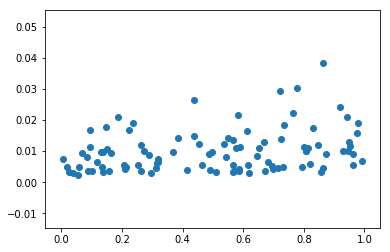

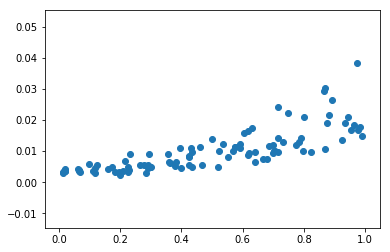

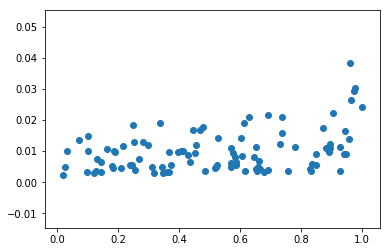

[0.01413664 0.00818705 0.02634118 0.01419193 0.01347243 0.00343789
 0.03030633 0.01131933 0.00648502 0.00988209 0.01209483 0.00359364
 0.01629383 0.00639011 0.00435295 0.00357375 0.0060485  0.01472264
 0.00412206 0.00536957 0.00364162 0.00330556 0.00581445 0.01684833
 0.01587755 0.00298883 0.00292475 0.00389677 0.00540055 0.01143555
 0.00749488 0.00449671 0.00439741 0.00740744 0.01849221 0.01089917
 0.01679278 0.01207761 0.01096163 0.02173411 0.01383565 0.00830582
 0.00499481 0.0087448  0.00484898 0.01139831 0.01099321 0.00958059
 0.00999991 0.02425648 0.01057738 0.00558522 0.01007264 0.00938513
 0.02917345 0.003244   0.00484858 0.00232874 0.00474462 0.01000437
 0.00945276 0.01894313 0.01225879 0.00467754 0.02109286 0.00378285
 0.00485477 0.00529528 0.00318926 0.01228659 0.00687046 0.00351487
 0.00641038 0.017468   0.0099885  0.01155163 0.0130064  0.00479537
 0.00542684 0.00556584 0.00463729 0.00956112 0.00325806 0.00905339
 0.0220836  0.00795358 0.0053844  0.00374747 0.01293994 0.0035

In [56]:
wb = np.array([0.5, 2.0, 0.9])

p_primed_dist = simple_affinity_model(background, wb, True)

print(p_primed_dist)

### Entropy maximization and MaxEnt

Having described how probabilities are computed from presence-only data in a series of locations, we turn now our attention to the problem of estimating the probability distribution that best matches existing data. In addition to recorded field data, we can state one more element of the *prior state of belief* about the distribution. This initial guess, namely $Q(x_i)$, can be used to compute the [Kullback-Liebler divergence metric](https://www.jstor.org/stable/2236703) that allows determining how similar is a predicted distribution with respect to the prior state of belief. For $N$ locations, the most reasonable prior distribution is that which assigns probability uniformly to all locations in the space, namely

$$Q(x_i) = 1/N$$

Back to our coding example, we define a function that generates a vector with the values of $Q$ for all locations intended to match predictions generated with a Poisson model.

In [18]:
def prior_distribution_poisson(n):
    return np.full(n, 1.0/n)

For instance, for our example, the outcome is as follows:

In [30]:
q_dist = prior_distribution_poisson(100)

print(q_dist)

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]


The Kullback-Liebler divergence is defined formally as a version of Shannon information weighted by the prior distrivution and is given by

$$\sum_{i = 1}^{N} P^*(\boldsymbol{z}(x_i)) \cdot \log \biggl[ \frac{P^*(\boldsymbol{z}(x_i))}{Q(x_i)} \biggr].$$

We proceed to define a function that depends on the dataset and a value of $\boldsymbol{\lambda}$ that can be used to perform the variation in the model. The corresponding code for the Kullback-Liebler divergence metric of two vectors is as follows. Thanks to the convenience of the **numpy** package, we can write the expression in a single line of code. 

In [48]:
def kullback_liebler_divergence(p, q):
    return np.sum(np.multiply(p, np.log(np.divide(p,q))))

We compute its values for the previous parametrizations of $\boldsymbol{\lambda}$:

In [52]:
print('K-L divergence for (1.0, 1.0, 1.0): ' + str(kullback_liebler_divergence(p_dist, q_dist)))

print('K-L divergence for (0.5, 2.0, 0.9): ' + str(kullback_liebler_divergence(p_primed_dist, q_dist)))

K-L divergence for (1.0, 1.0, 1.0): 0.13765797924228163
K-L divergence for (0.5, 2.0, 0.9): 0.20225889661789936


With a divergence (i.e. distance) metric under our belt, we are ready to maximize the similarity between the predicted values and presence-only data. The maximization procedure requires establishing constraints that link presence locations with the probability distribution of background variables. Note that for $N$ locations we only expect $M \leq N$ of them to contain data. The latter is equal to stating that the expected (simple) average for the $M$ locations for a given background variable should match the computed average for the whole set of locations. This restriction can be interpreted as follows: the average concerns only those locations where there is evidence of an effect of a variable $z_j$ over members of a species.

$$\sum_{i = 1}^{N} z_{j}(i) P^*(\boldsymbol{z}(x_i)) = \frac{1}{M} \sum_{k = 1}^{M} z_{j}(k)$$

The latter implies that $\mathrm{dim}(\boldsymbol{z})$ constraints need to be satisfied simultaneously during the optimization process. Being careful to choose only those variables that are relevant to the organism, and that potentially maximize the likelihood of highlighting differences when they exist also contributes to decreasing the computational complexity of the [constrained optimization](https://ieeexplore.ieee.org/abstract/document/4310262/) process.

Having understood the main methodological elements, we proceed to replicate the Phillips et al (2006) paper by solving the fitting problem for $\boldsymbol{\lambda}$ through a support vector machine.


## Code example 1: a realization of MaxEnt using *scikit-learn*

This code can be found as one of the [scikit examples](http://scikit-learn.org/stable/auto_examples/applications/plot_species_distribution_modeling.html). The dataset contained in this package does not contain vegetation data, which makes it ideal to compare against Fig. 4 in Phillips et al (2006).

### Steps

- First ensure that all relevant packages are installed using **pip**. Also, make sure that the package manager is at its latests version.

In [71]:
#!pip install --upgrade pip
#!pip install matplotlib
#!pip install scipy
#!pip install sklearn
#!pip install 'https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz'

     | 132.5MB 43.3MB/s    / 34.5MB 23.8MB/s     / 49.4MB 49.0MB/s     | 70.7MB 18.1MB/s     | 75.9MB 20.8MB/s     / 82.2MB 32.3MB/s     \ 107.4MB 21.7MB/s     | 112.5MB 31.5MB/s
    Complete output from command python setup.py egg_info:
    checking for GEOS lib in /home/jovyan ....
    checking for GEOS lib in /home/jovyan/local ....
    checking for GEOS lib in /usr ....
    checking for GEOS lib in /usr/local ....
    checking for GEOS lib in /sw ....
    checking for GEOS lib in /opt ....
    checking for GEOS lib in /opt/local ....
    
    Can't find geos library in standard locations ('/home/jovyan', '/home/jovyan/local', '/usr', '/usr/local', '/sw', '/opt', '/opt/local').
    Please install the corresponding packages using your
    systems software management system (e.g. for Debian Linux do:
    'apt-get install libgeos-3.3.3 libgeos-c1 libgeos-dev' and/or
    set the environment variable GEOS_DIR to point to the location
    where geos is installed (for example, if geos_c.h


- Importing of the relevant packages.

In [66]:
from __future__ import print_function

from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets.base import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn import svm, metrics

- Attempt to use basemaps, otherwise default to a simpler presentation.

In [67]:
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

- Define a funcion that, given a certain species name in Phillips et al (2006), species data and coverage data, generates a correctly labeled collection representing an instance of the MaxEnt problem.

In [68]:
def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch

- Solve the model and plot the data depending on the existing infrastructure. Note that in this model there is a differentiation between training data and test data that is not stated as such in the original paper that requires clarification.

In [69]:
def plot_species_distribution(species=("bradypus_variegatus_0",
                                       "microryzomys_minutus_0")):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print("Note: when more than two species are provided,"
              " only the first two will be used")

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(species[0],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny,
                                                size=10000),
                              np.random.randint(low=0, high=data.Nx,
                                                size=10000)].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    fig= plt.figure(figsize=(16,8))
    
    # Fit, predict, and plot for each species.
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ", end='')
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                        urcrnrlat=Y.max(), llcrnrlon=X.min(),
                        urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(X, Y, land_reference,
                        levels=[-9999], colors="k",
                        linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)[:, 0]
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'],
                    s=2 ** 2, c='black',
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'],
                    s=2 ** 2, c='black',
                    marker='x', label='test')
        plt.legend()
        plt.title(species.name.capitalize())
        plt.axis('equal')

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean)
                                          / std)[:, 0]
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))

Finally, call the function that computes the model and show the map.

________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution


/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"



 Area under the ROC curve : 0.868443
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.993919

time elapsed: 36.29s


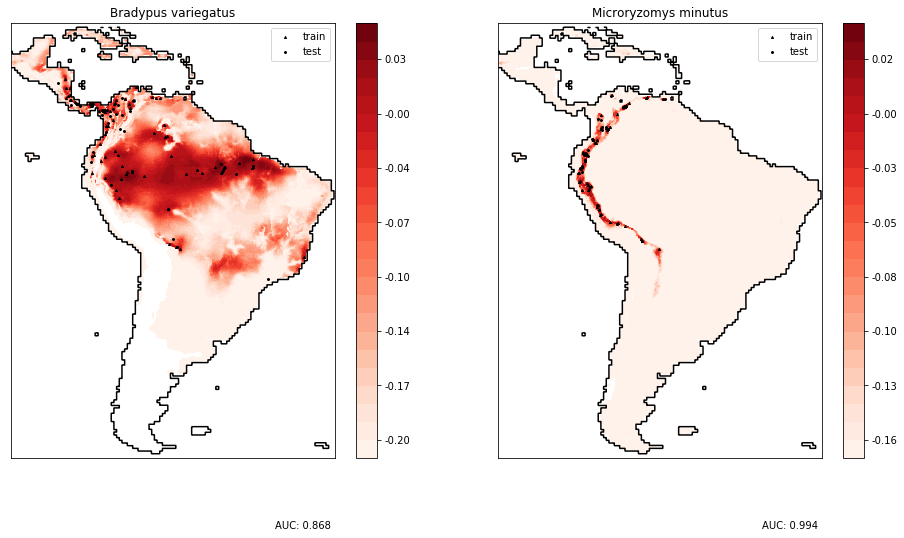

In [70]:
plot_species_distribution()
plt.show()

Now, we observe the images obtained from the paper.

<img src="bradypus.png" alt="Bradypus variegatus in Phillips et al (2006)" style="width: 350px;"/>
AUC = 0.873

<img src="minutus.png" alt="Microryzomys minutus in Phillips et al (2006)" style="width: 350px;"/>
AUC = 0.986

First, it is hard to make any appropriately informed assessments with the images that were reported. The color maps are not comparable, the original images being the coarser ones. A comparison using images would require utilizing a direct bitmap distance function between the same number of pixels and the same region. However, despite the limitations, there exist striking differences with respect to our computation. The AUC values are different, and correspond to different distributions. The most striking difference in the distribution occurs near the south of the Brazilian Atlantic coast for *Bradypus variegatus* and near the Pacific coast between Peru and Chile for *Microryzomys minutus*. 

While further research is required, we can safely state that this particular study could not be replicated.